In [ ]:
#install python packages to run this notebook
!pip install -q rasterio rasterstats geopandas lightgbm

In [ ]:
# Import Essential Libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

import lightgbm as lgb

import rasterio
import rasterstats
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import os
import pickle
from os import path as op


import rasterio
from rasterio.features import rasterize
from rasterstats.io import bounds_window

In [ ]:
# Mount drive to google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Set a Google Drive directory as the default working directory
root_dir = "/content/drive/My Drive/Machine Learning/Data"

# This is a Shared Drive with data copies (limited access)
#shared_dir = "/content/drive/Shared drives/servir-sat-ml/data"

# Make sure that folder exists
if (not op.isdir(root_dir)):
  os.mkdir(root_dir)

**Prepare Training Data**

We will be using an already prepared training dataset that consists of polygons of each land use classification. These polygons were prepared by people using GIS digitizing methods (QGIS, ArcGIS, JOSM) with satellite imagery to trace over

In [ ]:
# Read in the training data
training_vectors=gpd.read_file(os.path.join(root_dir,"training_data.geojson"))
training_vectors.head()

,name,description,geometry
0,Shadow,None,"MULTIPOLYGON (((34.83383 1.18204, 34.83577 1.1..."
1,Forestland,None,"MULTIPOLYGON (((35.30961 1.01328, 35.30964 1.0..."
2,Maize,early reproductive,"MULTIPOLYGON (((34.90904 1.09515, 34.90907 1.0..."
3,Sugarcane,no change..maize farm on the right and far lef...,"MULTIPOLYGON (((34.9075 1.08934, 34.90753 1.08..."
4,Maize,reproductive good crop,"MULTIPOLYGON (((34.87144 0.82953, 34.87147 0.8..."


In [ ]:
# Find all unique values of training data names to use as classes
classes=np.unique(training_vectors.name)
# classes=np.array(sorted(training_vectors.name.unique()))
classes

array(['Built', 'Cloud', 'Fallow', 'Forestland', 'Grassland', 'Maize',
       'Shadow', 'Sugarcane', 'Sunflower', 'Waterbody'], dtype=object)

**By assigning numeric ID to each class**

In [ ]:
# Create a distionary to convert class names into integers for modeling
class_dict=dict(zip(classes,range(len(classes))))
class_dict

{'Built': 0,
 'Cloud': 1,
 'Fallow': 2,
 'Forestland': 3,
 'Grassland': 4,
 'Maize': 5,
 'Shadow': 6,
 'Sugarcane': 7,
 'Sunflower': 8,
 'Waterbody': 9}

**Preparing Imagery**

In [ ]:
!pip install earthengine-api

In [ ]:
# Authenticate to my GEE account
!earthengine authenticate
import ee
ee.Initialize()

E0000 00:00:1770786965.133982    6052 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770786965.140779    6052 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770786965.157103    6052 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770786965.157148    6052 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770786965.157153    6052 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770786965.157158    6052 computation_placer.cc:177] computation placer already registered. Please check linka

In [ ]:
# From GEE
#training_vectors.total_bounds.tolist()
aoi = ee.Geometry.Rectangle(training_vectors.total_bounds.tolist())
band_sel = ('B2', 'B3', 'B4', 'B8', 'B11', 'B12')

sentinel_scenes = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
    .filterBounds(aoi)\
    .filterDate('2019-05-02', '2019-05-03')\
    .select(band_sel)

scenes = sentinel_scenes.getInfo()
[print(scene['id']) for scene in scenes["features"]]

sentinel_mosaic = sentinel_scenes.mean().rename(band_sel)

COPERNICUS/S2_HARMONIZED/20190502T074621_20190502T080204_T36NXF
COPERNICUS/S2_HARMONIZED/20190502T074621_20190502T080204_T36NXG
COPERNICUS/S2_HARMONIZED/20190502T074621_20190502T080204_T36NYF
COPERNICUS/S2_HARMONIZED/20190502T074621_20190502T080204_T36NYG


In [ ]:
# We will save it to Google Drive for later reuse
raster_name = op.join(root_dir,'sentinel_mosaic-Trans_Nzoia')

# **Model Training**

# **Preparing Data**
First we will need to do some preparation to organize the training data into the correct python types, and to extract sample pixels from the intersecting imagery

In [ ]:
%%time

# raster information
raster_file = op.join(root_dir, 'sentinel_mosaic-Trans_Nzoia.tif')
# raster_file = '/content/drive/Shared drives/servir-sat-ml/data/gee_sentinel_mosaic-Trans_Nzoia.tif'

# a custom function for getting each value from the raster
def all_values(x):
    return x

# this larger cell reads data from a raster file for each training vector
X_raw = []
y_raw = []
with rasterio.open(raster_file, 'r') as src:
    for (label, geom) in zip(training_vectors.name, training_vectors.geometry):
        # read the raster data matching the geometry bounds
        window = bounds_window(geom.bounds, src.transform)
        # store our window information
        window_affine = src.window_transform(window)
        fsrc = src.read(window=window)
        # rasterize the (non-buffered) geometry into the larger shape and affine
        mask = rasterize(
            [(geom, 1)],
            out_shape=fsrc.shape[1:],
            transform=window_affine,
            fill=0,
            dtype='uint8',
            all_touched=True
        ).astype(bool)
        # for each label pixel (places where the mask is true)...
        label_pixels = np.argwhere(mask)
        for (row, col) in label_pixels:
            # add a pixel of data to X
            data = fsrc[:,row,col]
            one_x = np.nan_to_num(data, nan=1e-3)
            X_raw.append(one_x)
            # add the label to y
            y_raw.append(class_dict[label])

CPU times: user 8.69 s, sys: 1.97 s, total: 10.7 s
Wall time: 25.4 s


Now we need to put the data in arrays (numpy in this case), so that each row cell represents data, repeated over 6 bands (in this case columns). The shape property shows us the dimensions of the stored data.

In [ ]:
# convert the training data lists into the appropriate shape and format for scikit-learn
X = np.array(X_raw)
y = np.array(y_raw)
(X.shape, y.shape)

((145347, 6), (145347,))

In addition to the raw pixel values we will calculated a couple of indices that help in some classifications.

Normalized Difference Vegetation Index (NDVI) - great for identiying photosynthesizing plants.
Normalized Difference Water Index (NDWI) - great for identifying open water (when there isn't a lot of glare)

In [ ]:
 #(optional) add extra band indices

# helper function for calculating ND*I indices (bands in the final dimension)
def band_index(arr, a, b):
    return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)

ndvi = band_index(X, 3, 2)
ndwi = band_index(X, 1, 3)

X = np.concatenate([X, ndvi, ndwi], axis=1)
X.shape

(145347, 8)

Now were going to split 20% of the data to reserve for testing the quality of the trained model.

In [ ]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Since we don't have the same amount of training data for each class, we're going to calculate the relative quantities and tell the model so it can adjust to reduce bias.

In [ ]:
# calculate class weights to allow for training on inbalanced training samples
labels, counts = np.unique(y_train, return_counts=True)
class_weight_dict = dict(zip(labels, 1 / counts))
class_weight_dict

{np.int64(0): np.float64(0.0004657661853749418),
 np.int64(1): np.float64(0.0015873015873015873),
 np.int64(2): np.float64(0.0004945598417408506),
 np.int64(3): np.float64(2.1623024196164074e-05),
 np.int64(4): np.float64(0.0009199632014719411),
 np.int64(5): np.float64(1.7606563726957408e-05),
 np.int64(6): np.float64(0.00024740227610094015),
 np.int64(7): np.float64(0.00033344448149383126),
 np.int64(8): np.float64(0.05263157894736842),
 np.int64(9): np.float64(0.003484320557491289)}

# **Train LightGBM**

In [ ]:
%%time
# initialize a lightgbm

lgbm = lgb.LGBMClassifier(
       objective='multiclass',
       class_weight = class_weight_dict,
       num_class = len(class_dict),
       metric = 'multi_logloss')

CPU times: user 1.45 ms, sys: 28 µs, total: 1.48 ms
Wall time: 1.78 ms


In [ ]:
%%time
# fit the model to the data (training)
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 116277, number of used features: 8
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

LGBMClassifier(class_weight={np.int64(0): np.float64(0.0004657661853749418),
                             np.int64(1): np.float64(0.0015873015873015873),
                             np.int64(2): np.float64(0.0004945598417408506),
                             np.int64(3): np.float64(2.1623024196164074e-05),
                             np.int64(4): np.float64(0.0009199632014719411),
                             np.int64(5): np.float64(1.7606563726957408e-05),
                             np.int64(6): np.float64(0.00024740227610094015),
                             np.int64(7): np.float64(0.00033344448149383126),
                             np.int64(8): np.float64(0.05263157894736842),
                             np.int64(9): np.float64(0.003484320557491289)},
               metric='multi_logloss', num_class=10, objective='multiclass')

# **XGBoost (Optional)**

In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb
xgboost=xgb.XGBClassifier()

In [ ]:
para_dict={
    'learning_rate':[0.001,0.1,0.5],
    'n_estimators':[150,200,300,1000]
}

In [ ]:
from sklearn.model_selection import GridSearchCV
grid_search=GridSearchCV(xgboost,param_grid=para_dict,cv=2)

In [ ]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.001, 0.1, 0.5],
                         'n_estimators': [150, 200, 300, 1000]})

In [ ]:
 grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
Model=xgb.XGBClassifier(max_depth=30, learning_rate=0.5, n_estimators=150, n_jobs=-1, class_weight = class_weight_dict)

In [ ]:
%%time
Model.fit(X_train,y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:15:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CPU times: user 47.9 s, sys: 338 ms, total: 48.3 s
Wall time: 28.2 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight={np.int64(0): np.float64(0.0004657661853749418),
                            np.int64(1): np.float64(0.0015873015873015873),
                            np.int64(2): np.float64(0.0004945598417408506),
                            np.int64(3): np.float64(2.1623024196164074e-05),
                            np.int64(4): np.float64(0.0009199632014719411),
                            np.int64(5): np.float64(1.7606563726957408e-05),...
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.5, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=30,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=-1, ...)

In [ ]:
xgb_prediction=Model.predict(X_test)

In [ ]:
xgb_confusion_matrix=confusion_matrix(y_test,xgb_prediction)
xgb_confusion_matrix

array([[  507,     0,     0,     0,     0,    40,     6,     0,     0,
            0],
       [    0,    83,     0,     1,     0,    35,    13,     0,     0,
            0],
       [    0,     0,   455,    30,     0,    11,     2,     0,     0,
            0],
       [    0,     0,    32, 11473,     0,    27,     1,     0,     0,
            0],
       [    0,     0,     0,     1,   199,    47,     1,     9,     0,
            0],
       [   14,    15,     7,    64,    24, 13620,   125,   381,     0,
            1],
       [   10,     7,     0,     4,     1,   305,   709,     5,     0,
            0],
       [    0,     2,     0,     0,     3,   399,     2,   331,     0,
            0],
       [    0,     0,     0,     0,     0,     0,     1,     0,     2,
            0],
       [    0,     0,     0,     1,     0,     1,     0,     0,     0,
           63]])

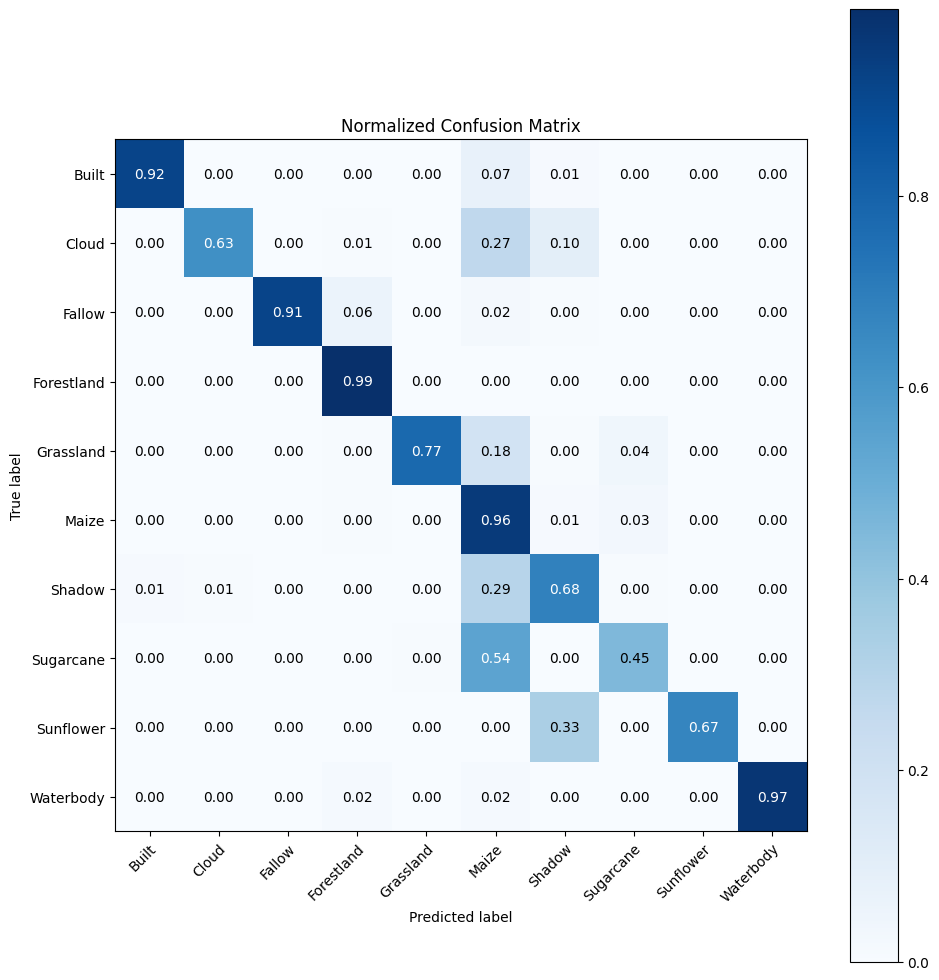

In [ ]:
# Plot the confusion matrix for XGBoost
%matplotlib inline
cm = xgb_confusion_matrix.astype('float') / xgb_confusion_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

# **Assess the Model of LightGBM**
Now we use the reserved test data to evaluate how well the model is able to predict.

In [ ]:
# Predict on X-test to evaluate the model
pred=lgbm.predict(X_test)
cm=confusion_matrix(y_test,pred)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


# **Accuracy Matrices**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

In [ ]:
# Overall accuracy
accuracy = accuracy_score(y_test, pred)
print(f"Overall Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")

# Detailed metrics: precision, recall, F1-score per class
report = classification_report(y_test, pred, target_names=classes, labels=list(class_dict.values()))
print("\nClassification Report:\n")
print(report)

Overall Accuracy: 0.8935 (89.35%)

Classification Report:

              precision    recall  f1-score   support

       Built       0.85      0.95      0.90       553
       Cloud       0.33      0.86      0.47       132
      Fallow       0.73      0.96      0.83       498
  Forestland       0.99      0.99      0.99     11533
   Grassland       0.49      0.92      0.64       257
       Maize       0.99      0.81      0.89     14251
      Shadow       0.42      0.86      0.57      1041
   Sugarcane       0.45      0.94      0.61       737
   Sunflower       0.75      1.00      0.86         3
   Waterbody       0.93      0.98      0.96        65

    accuracy                           0.89     29070
   macro avg       0.69      0.93      0.77     29070
weighted avg       0.94      0.89      0.91     29070



**Compute ROC curve with AUC**

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


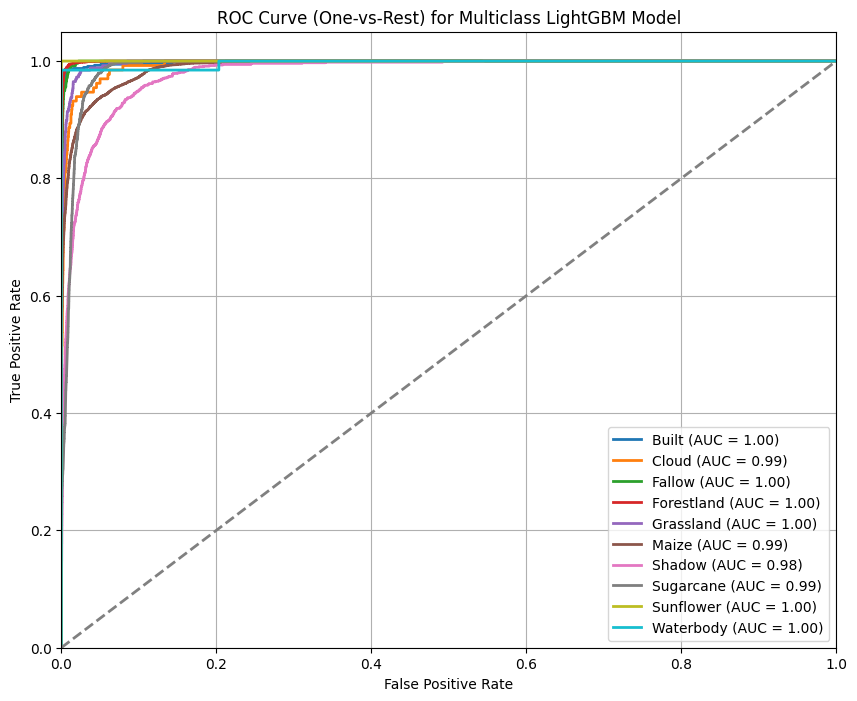


Macro-Averaged AUC: 0.9943


In [ ]:
# Get predicted probabilities (needed for ROC)
y_prob = lgbm.predict_proba(X_test)

# Binarize the labels for multiclass ROC (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=list(class_dict.values()))
n_classes = y_test_bin.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_prob[:, i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    class_name = classes[i]
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest) for Multiclass LightGBM Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print average AUC
macro_auc = roc_auc_score(y_test_bin, y_prob, average='macro')
print(f"\nMacro-Averaged AUC: {macro_auc:.4f}")

**And we can save a copy of the model for later resuse without the need to retrain.**

In [ ]:
model_name='light_gbm.sav'
pickle.dump(lgbm,open(op.join(root_dir,model_name),'wb'))

# **Confusion Matrix for LightGBM**

A confusion matrix shows a comparision between what the class is based on the test data, and what the model predicted it to be. Low numbers are good. The diagonal from top left to bottom right, is a class compared to itself should be high. Values range from 0 to 1.

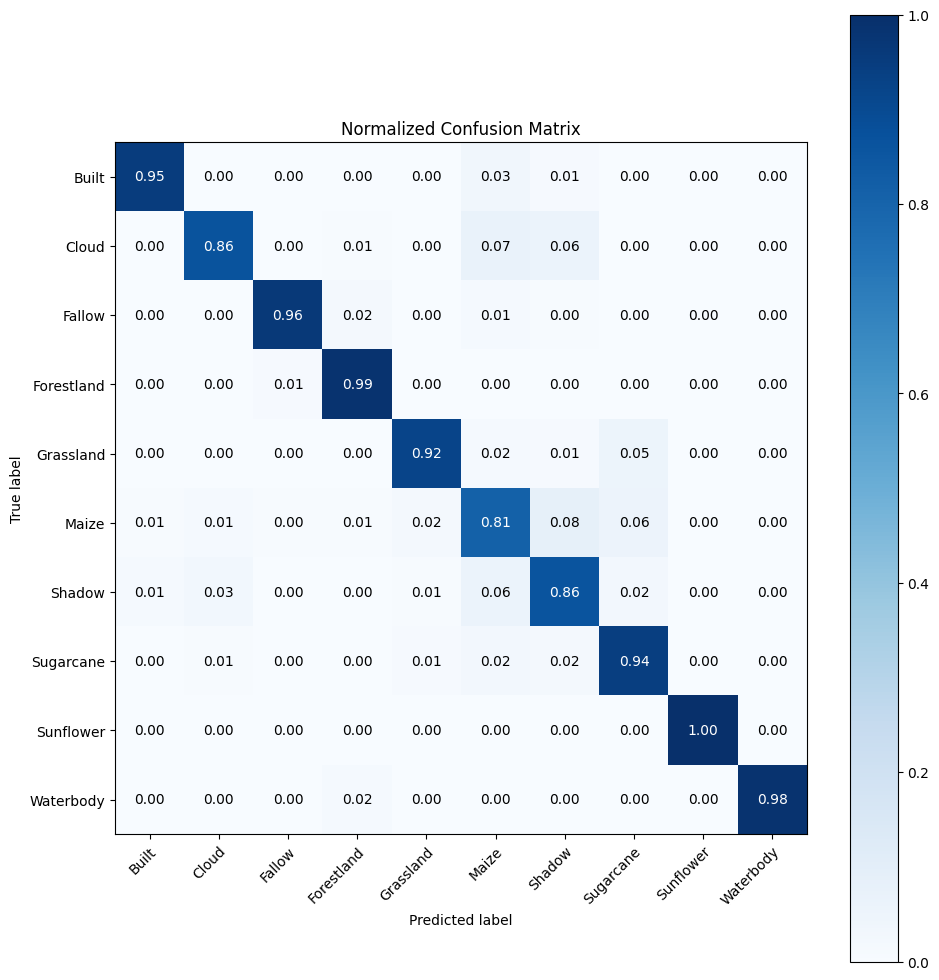

In [ ]:
# plot the confusion matrix
%matplotlib inline
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

# **Generate Predictions Over the Full Image**

**Load the Model**

We can load the model we saved previously, so that we don't have to do all the work in the same session.

In [ ]:
# if you want to use the pretrained model for new imagery

# match the pretrained model weight with the saved model above
model_name = 'light_gbm.sav'

# helper function for calculating ND*I indices (bands in the final dimension)
def band_index(arr, a, b):
    return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)

lgbm = pickle.load(open(op.join(root_dir, model_name), 'rb'))

In [ ]:
lgbm

LGBMClassifier(class_weight={np.int64(0): np.float64(0.0004657661853749418),
                             np.int64(1): np.float64(0.0015873015873015873),
                             np.int64(2): np.float64(0.0004945598417408506),
                             np.int64(3): np.float64(2.1623024196164074e-05),
                             np.int64(4): np.float64(0.0009199632014719411),
                             np.int64(5): np.float64(1.7606563726957408e-05),
                             np.int64(6): np.float64(0.00024740227610094015),
                             np.int64(7): np.float64(0.00033344448149383126),
                             np.int64(8): np.float64(0.05263157894736842),
                             np.int64(9): np.float64(0.003484320557491289)},
               metric='multi_logloss', num_class=10, objective='multiclass')

# **Run the Model on Whole area**

Now that we've trained and tested the model over the existing data we can use the trained LightGBM classifier `lgbm` over a whole satellite image that covers a larger geospatial location. We can split the job into small tiles to optimize the compute power and potentially do the classification in parallel.

In [ ]:
%%time
# open connections to our input and output images

# new_image = op.join(root_dir, 'Trans_nzoia_2019_10-04.tif')
raster_file = '/content/drive/Shared drives/servir-sat-ml/data/gee_sentinel_mosaic-Trans_Nzoia.tif'
new_image = raster_file
output_image = op.join(root_dir, "lgbm_classification.tif")

with rasterio.open(new_image, 'r') as src:
  profile = src.profile
  profile.update(
      dtype=rasterio.uint8,
      count=1,
  )

  with rasterio.open(output_image, 'w', **profile) as dst:

    # perform prediction on each small image patch to minimize required memory
    patch_size = 500

    for i in range((src.shape[0] // patch_size) + 1):
        for j in range((src.shape[1] // patch_size) + 1):
            # define the pixels to read (and write)
            window = rasterio.windows.Window(
                j * patch_size,
                i * patch_size,
                # don't read past the image bounds
                min(patch_size, src.shape[1] - j * patch_size),
                min(patch_size, src.shape[0] - i * patch_size)
            )

            data = src.read(window=window)
            # read the image into the proper format, adding indices if necessary
            img_swp = np.moveaxis(data, 0, 2)
            img_flat = img_swp.reshape(-1, img_swp.shape[-1])

            img_ndvi = band_index(img_flat, 3, 2)
            img_ndwi = band_index(img_flat, 1, 3)

            img_w_ind = np.concatenate([img_flat, img_ndvi, img_ndwi], axis=1)

            # remove no data values, store the indices for later use
            # a later cell makes the assumption that all bands have identical no-data value arrangements
            m = np.ma.masked_invalid(img_w_ind)
            to_predict = img_w_ind[~m.mask].reshape(-1, img_w_ind.shape[-1])

            # predict
            if not len(to_predict):
                continue
            img_preds = lgbm.predict(to_predict)

            # add the prediction back to the valid pixels (using only the first band of the mask to decide on validity)
            # resize to the original image dimensions
            output = np.zeros(img_flat.shape[0])
            output[~m.mask[:,0]] = img_preds.flatten()
            output = output.reshape(*img_swp.shape[:-1])

            # create our final mask
            mask = (~m.mask[:,0]).reshape(*img_swp.shape[:-1])

            # write to the final file
            dst.write(output.astype(rasterio.uint8), 1, window=window)
            dst.write_mask(mask, window=window)
            # write to the final file
            dst.write(output.astype(rasterio.uint8), 1, window=window)
            dst.write_mask(mask, window=window)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

CPU times: user 1h 26min 27s, sys: 5.31 s, total: 1h 26min 32s
Wall time: 1h 27min 54s


# **Explore the Results**

<Axes: title={'center': 'Sentinel 2 RGB'}>

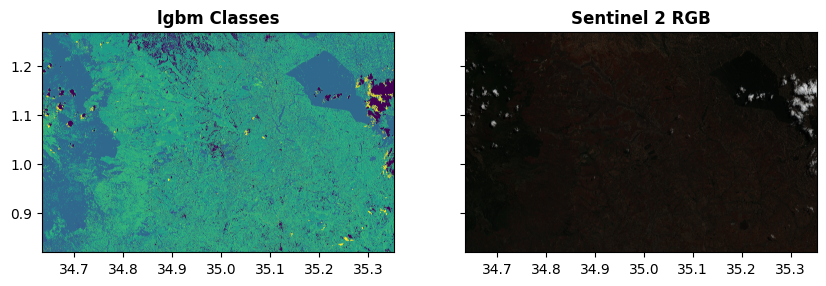

In [ ]:
import matplotlib.pyplot as plt
from rasterio.plot import show
%matplotlib inline


# Load the classification
if os.path.exists(op.join(root_dir, "lgbm_classification.tif")):
  output_image = op.join(root_dir, "lgbm_classification.tif")
else:
  output_image = '/content/drive/Shared drives/servir-sat-ml/data/lgbm_classification.tif'


def linear_rescale(image, in_range=(0, 1), out_range=(1, 255)):
    imin, imax = in_range
    omin, omax = out_range
    image = np.clip(image, imin, imax) - imin
    image = image / np.float(imax - imin)
    return image * (omax - omin) + omin

with rasterio.open(output_image, 'r') as class_raster:
#  show(class_raster)
  lgbm_classes = class_raster.read()


# Load the original image
with rasterio.open(raster_file, 'r') as s2_raster:
#  show(s2_raster)
  s2 = s2_raster.read([1,2,3])

# Compare side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), sharey=True)
show(lgbm_classes, transform=class_raster.transform, ax=ax1, title="lgbm Classes")
show(s2[[2,1,0], : , :], transform=s2_raster.transform, adjust='linear', ax=ax2, title="Sentinel 2 RGB")

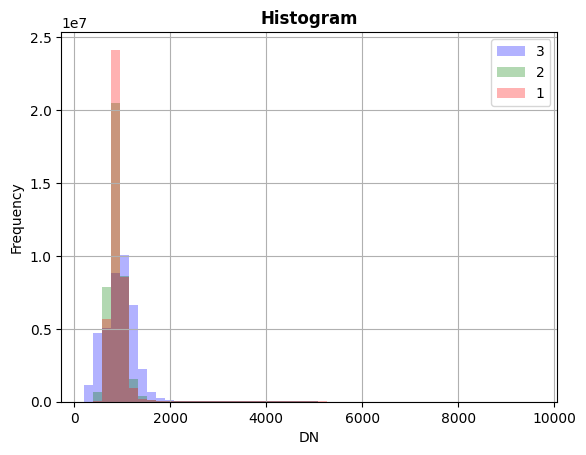

In [ ]:
# The satellite image isn't right, lets see why
rasterio.plot.show_hist(s2,
                   bins=50,
                   histtype='stepfilled',
                   lw=0.0,
                   stacked=False,
                   alpha=0.3)

In [ ]:
# Based on the histogram we'll set a threshold and rescale the data for visualization
# The values used for in_range are going to depend on the datatype and range of your data
# If you got the data from GEE try in_range(0, 2500)
def linear_rescale(image, in_range=(0, 1), out_range=(1, 255)):
    imin, imax = in_range
    omin, omax = out_range
    image = np.clip(image, imin, imax) - imin
    image = image / np.float64(imax - imin)
    return image * (omax - omin) + omin

for band in range(s2.shape[0]):
    s2[band] = linear_rescale(
            s2[band],
            #in_range=(0, 0.25),
            in_range=(0, 2500),
            out_range=[0, 255]
        )
s2 = s2.astype(np.uint8)

<Axes: title={'center': 'Sentinel 2 RGB'}>

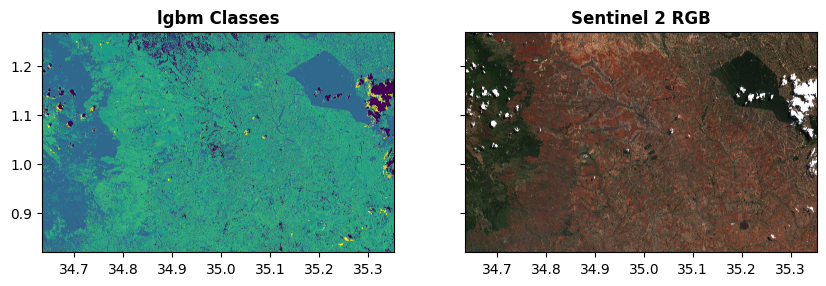

In [ ]:
# Now retry the plot
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), sharey=True)
show(lgbm_classes, transform=class_raster.transform, ax=ax1, title="lgbm Classes")
show(s2[[2,1,0], : , :], transform=s2_raster.transform, adjust='linear', ax=ax2, title="Sentinel 2 RGB")

# **Compare LightGBM and Random Forest**

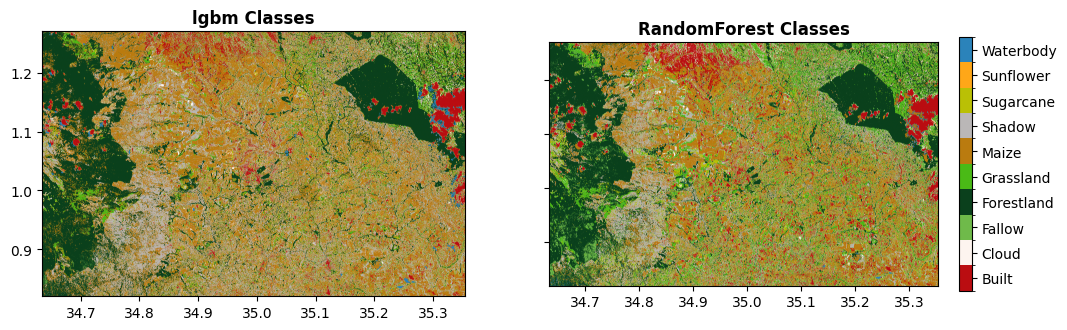

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors

# Load the classification
if os.path.exists(op.join(root_dir, "RF_classification.tif")):
  output_image = op.join(root_dir, "RF_classification.tif")
else:
  output_image = '/content/drive/Shared drives/servir-sat-ml/data/RF_classification.tif'

with rasterio.open(output_image, 'r') as rf_class_raster:
#  show(class_raster)
  rf_classes = rf_class_raster.read()

cls_colors = ['#ba0d11',
              '#fdf4ef',
              '#6fba4a',
              '#0a401c',
              '#4aba16',
              '#ba7b0f',
              '#bab7b7',
              '#bac005',
              '#ffa718',
              '#2b83ba']
clr_land = colors.ListedColormap([colors.hex2color(x) for x in cls_colors])



fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12, 6), sharey=True)

im1 = ax1.imshow(lgbm_classes.squeeze(), cmap=cm.Accent_r)
show(lgbm_classes,
     transform=class_raster.transform,
     ax=ax1,
     title="lgbm Classes",
     cmap=clr_land
     )

show(rf_classes,
     transform=rf_class_raster.transform,
     ax=ax2,
     title="RandomForest Classes",
     cmap=clr_land
     )

# Now make a colorbar
# Corrected: BoundaryNorm should use np.arange(N+1) for N classes (0 to N-1)
# Corrected: set_ticks should generate N ticks for N labels
norm = colors.BoundaryNorm(np.arange(len(class_dict) + 1), clr_land.N)
cb = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=clr_land), ax=ax2, fraction=0.03)
cb.set_ticks([x + 0.5 for x in range(len(class_dict))]) # move the marks to the middle
cb.set_ticklabels(list(class_dict.keys())) # label the colors

Render my Classified Image

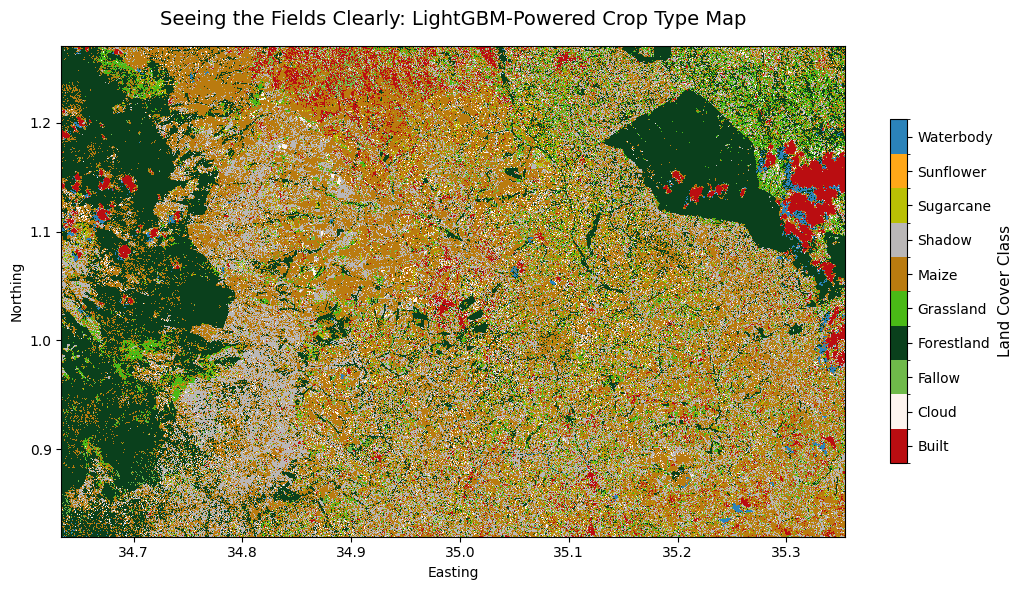

In [ ]:
import os
import rasterio
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

# =====================================
#  Define paths
# =====================================
root_dir = "/content/drive/My Drive/Machine Learning/Data"

# Choose the correct path (you can keep this logic)
if os.path.exists(os.path.join(root_dir, "lgbm_classification.tif")):
    output_image = os.path.join(root_dir, "lgbm_classification.tif")
else:
    # fallback path - change this to your actual file name if different
    output_image = '/content/drive/Shared drives/servir-sat-ml/data/lgbm_classification.tif'

# =====================================
#  Your class names and colors
# =====================================
class_names = ['Built', 'Cloud', 'Fallow', 'Forestland', 'Grassland',
               'Maize', 'Shadow', 'Sugarcane', 'Sunflower', 'Waterbody']

cls_colors = [
    '#ba0d11',    # Built
    '#fdf4ef',    # Cloud
    '#6fba4a',    # Fallow
    '#0a401c',    # Forestland
    '#4aba16',    # Grassland
    '#ba7b0f',    # Maize
    '#bab7b7',    # Shadow
    '#bac005',    # Sugarcane
    '#ffa718',    # Sunflower
    '#2b83ba'     # Waterbody
]

# Create colormap
clr_land = colors.ListedColormap(cls_colors)

# =====================================
#  Load and visualize
# =====================================
with rasterio.open(output_image, 'r') as src:

    # Read the classification (usually band 1)
    classified_data = src.read(1)           # shape: (height, width)

    # Get spatial info for correct display
    transform = src.transform
    extent = rasterio.plot.plotting_extent(src)

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Display the classification
    im = ax.imshow(
        classified_data,
        cmap=clr_land,
        extent=extent,
        interpolation='nearest'
    )

    # Title and labels
    ax.set_title("Seeing the Fields Clearly: LightGBM-Powered Crop Type Map", fontsize=14, pad=15)
    ax.set_xlabel("Easting")
    ax.set_ylabel("Northing")

    # Create colorbar with class names
    norm = colors.BoundaryNorm(np.arange(len(class_names) + 1), clr_land.N)
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=clr_land),
        ax=ax,
        orientation='vertical',
        shrink=0.7,
        pad=0.04
    )

    # Put ticks in the middle of each color block
    cbar.set_ticks(np.arange(len(class_names)) + 0.5)
    cbar.set_ticklabels(class_names, fontsize=10)
    cbar.set_label('Land Cover Class', fontsize=11)

    plt.tight_layout()
    plt.show()

# **Explainable AI**

<Figure size 1000x700 with 0 Axes>

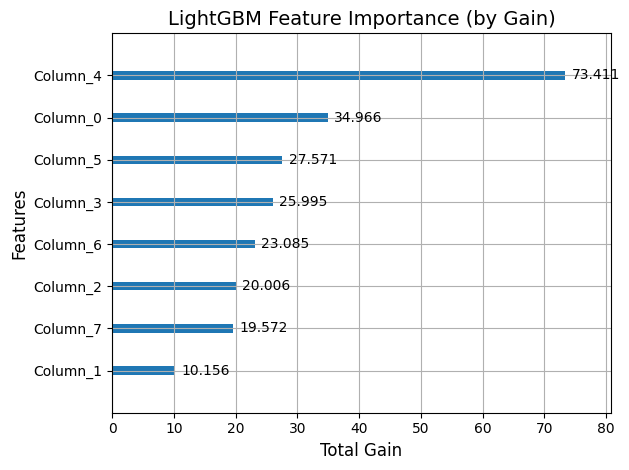

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import pickle

# 1. Load the saved LightGBM model
model_path = '/content/drive/My Drive/Machine Learning/Data/light_gbm.sav'  # ← change this to your actual file path if needed

with open(model_path, 'rb') as file:
    lgbm = pickle.load(file)

# 2. Plot feature importance
plt.figure(figsize=(10, 7))
lgb.plot_importance(
    lgbm,
    importance_type='gain',       # 'gain', 'split', or 'weight'
    max_num_features=15,
    grid=True
    # Removed: 'show_values' parameter as it caused an AttributeError
)
plt.title("LightGBM Feature Importance (by Gain)", fontsize=14)
plt.xlabel("Total Gain", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()